In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.callbacks import TensorBoard
from keras import backend as K


import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from IPython import display
import time
import random

img_rows, img_cols, img_depth = 64, 64, 64

/home/xd/ws/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/xd/ws/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [64]:
root_dir = 'dataset/train/'
listing = os.listdir(root_dir)
listing = sorted(listing)

classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}
gs_class = {'left', 'right', 'click', 'wrist'}
num_classes = len(classes)

In [53]:
def set_groundtruth(filename):
    gs_class = {'left', 'right', 'click', 'wrist'}
    gt = 'none'
    for i in gs_class:
        idx = filename.find(i)
        if idx != -1:
            gt = i
            return gt

In [57]:
def generate_data_from_folder(root_dir):
    X = []
    y = []
    
    listing = os.listdir(root_dir)
    listing = sorted(listing)
    width = 128 # input image shape = [width, width, 3]
    delta = 24 # 24*0.625cm = 15cm
    esp = 1e-6

    for file in listing:
        
        # set ground truth
        gt = set_groundtruth(file)
        
        file = root_dir + file
        data = scipy.io.loadmat(file)
        
        raw = data['raw']
        label = data['label']
        speed = data['speed']
        phase = data['phase']
        mask = data['mask']
    
        label_mask = (label != 0)
        label_sum = np.sum(label_mask) # total frames of labels
    
        gs_mask = mask[label_mask[:,0], :]
        gs_window = np.sum(gs_mask, 0) / label_sum
        maxval = np.max(gs_window[width:])
        maxidx = np.argmax(gs_window[width:])
    
        if maxval < 0.3:
            continue
        
        gesture_index, b = np.nonzero(label)
    
        # set gesture region, [r_min:r_max, c_min:c_max]
        r_min, r_max = gesture_index[0], gesture_index[-1]
        r_min = max(r_min - delta, 0)
        r_max = max(r_min + width + delta, r_max)
        r_max = min(r_max, len(label))

        body_pos = maxidx + width
        c_min = body_pos - width
        c_max = min(body_pos + delta, raw.shape[1])
    
        if (r_max - r_min < width) or (c_max - c_min < width):
            print(str(c_max-c_min) + ',' + str(r_max-r_min))
            continue
    
        raw_rdm = raw[r_min:r_max, c_min:c_max]
        maxval = np.max(np.abs(raw_rdm)) + esp
        raw_rdm = raw_rdm / maxval
    
        speed_rdm = speed[r_min:r_max, c_min:c_max]
        maxval = np.max(np.abs(speed_rdm)) + esp
        speed_rdm = speed_rdm / maxval
    
        phase_rdm = phase[r_min:r_max, c_min:c_max]
        maxval = np.max(np.abs(phase_rdm)) + esp
        phase_rdm = phase_rdm / maxval
    
        raw_input = np.zeros((r_max-r_min, c_max-c_min, 3))
        raw_input[:,:,0] = raw_rdm
        raw_input[:,:,1] = speed_rdm
        raw_input[:,:,2] = phase_rdm
        X.append(raw_input)
        y.append(classes[gt])

        # generate negtive samples
        if random.random() > 0.25:
            continue
        gt = 'none'
        r_min = int((gesture_index[0] + gesture_index[-1]) / 2)
        r_max = len(label)

        body_pos = maxidx + width
        c_min = body_pos - width
        c_max = min(body_pos + delta, raw.shape[1])
    
        if (r_max - r_min < width) or (c_max - c_min < width):
            print(str(c_max-c_min) + ',' + str(r_max-r_min))
            continue
    
        raw_rdm = raw[r_min:r_max, c_min:c_max]
        maxval = np.max(np.abs(raw_rdm)) + esp
        raw_rdm = raw_rdm / maxval
    
        speed_rdm = speed[r_min:r_max, c_min:c_max]
        maxval = np.max(np.abs(speed_rdm)) + esp
        speed_rdm = speed_rdm / maxval
    
        phase_rdm = phase[r_min:r_max, c_min:c_max]
        maxval = np.max(np.abs(phase_rdm)) + esp
        phase_rdm = phase_rdm / maxval
    
        raw_input = np.zeros((r_max-r_min, c_max-c_min, 3))
        raw_input[:,:,0] = raw_rdm
        raw_input[:,:,1] = speed_rdm
        raw_input[:,:,2] = phase_rdm
    
        X.append(raw_input)
        y.append(classes[gt])
    return np.array(X), np.array(y)

In [70]:
X_train, y_train = generate_data_from_folder('dataset/train/')
X_val, y_val = generate_data_from_folder('dataset/test/')

152,107


In [71]:
labels = np.zeros((5))
for i in range(0, 5):
    labels[i] = np.sum(y_train == i)
    
print('y_train label:')
for i in range(5):
    print(labels[i])
    

y_train label:
161.0
155.0
175.0
157.0
166.0


In [72]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = np_utils.to_categorical(y_val, num_classes)

num_filters = [32, 32]
num_pool = [2, 4]
num_conv = [5, 3]

# X = X.astype('float32')

In [73]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
batch_size = 32
num_classes = 5
num_epoch = 100
train_size = len(X_train)
val_size = len(X_val)

In [87]:
K.clear_session()
model = Sequential()

model.add(Conv2D(8,
                 (3, 3),
                 input_shape=(128, 128, 3),
                 activation='relu',
                 padding='SAME'))
model.add(Conv2D(8,
                 (3, 3),
                 activation='relu',
                 padding='SAME'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(16,
                 (3, 3),
                 activation='relu',
                 padding='SAME'))
model.add(Conv2D(16,
                 (3, 3),
                 activation='relu',
                 padding='SAME'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
__________

In [76]:
def generate_val_data(x, y):
    list_x = []
    list_y = []
    count = 0
    index = np.arange(len(x))
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    for i in range(len(x)):
        raw = x[i]
        sz = raw.shape
        
        label = np.argmax(y[i,:])
        num = 50
        
        for j in range(num):
            r = random.randint(0, sz[0]-128)
            c = random.randint(0, sz[1]-128)
            list_x.append(raw[r:r+128,c:c+128,:])
            list_y.append(y[i])
    return np.array(list_x), np.array(list_y)

In [77]:
X_val_aug, y_val_aug = generate_val_data(X_val, y_val)

In [78]:
gt = np.zeros((5))
for i in range(len(y_val_aug)):
    label = np.argmax(y_val_aug[i,:])
    gt[label] += 1
gt

array([1700., 2000., 1950., 1950., 2000.])

In [88]:
def generate_data(x, y, batch_size):
    list_x = []
    list_y = []
    count = 0
    index = np.arange(len(x))
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    while True:
        for i in range(len(x)):
            raw = x[i]
            sz = raw.shape
            
            label = np.argmax(y[i,:])
            num = 500
            
            for j in range(num):
                r = random.randint(0, sz[0]-128)
                c = random.randint(0, sz[1]-128)
                list_x.append(raw[r:r+128,c:c+128,:])
                list_y.append(y[i])
                count += 1
                if count >= batch_size:
                    yield (np.array(list_x), np.array(list_y))
                    count = 0
                    list_x = []
                    list_y = []
                        
generator = generate_data(X_train, y_train, batch_size)
hist = model.fit_generator(generator=generator,
                    validation_data=(X_val_aug, y_val_aug),
                    epochs=num_epoch, 
                    steps_per_epoch=(train_size*500)//batch_size,
#                     validation_steps=val_size//batch_size,
                    callbacks=[TensorBoard(log_dir='./tmp/log')]
                   )

Epoch 1/100
12718/12718 [==============================] - 210s 17ms/step - loss: 7.9459 - mean_squared_error: 0.2116 - acc: 0.4444 - val_loss: 7.4206 - val_mean_squared_error: 0.3286 - val_acc: 0.1771
Epoch 2/100
12718/12718 [==============================] - 232s 18ms/step - loss: 2.4064 - mean_squared_error: 0.0797 - acc: 0.7729 - val_loss: 6.5621 - val_mean_squared_error: 0.3277 - val_acc: 0.1771
Epoch 3/100
12718/12718 [==============================] - 241s 19ms/step - loss: 12.4236 - mean_squared_error: 0.3095 - acc: 0.2247 - val_loss: 12.7602 - val_mean_squared_error: 0.3167 - val_acc: 0.2083
Epoch 4/100
12718/12718 [==============================] - 269s 21ms/step - loss: 10.7371 - mean_squared_error: 0.2719 - acc: 0.3105 - val_loss: 12.7475 - val_mean_squared_error: 0.3165 - val_acc: 0.2085
Epoch 5/100
12718/12718 [==============================] - 255s 20ms/step - loss: 12.3697 - mean_squared_error: 0.3084 - acc: 0.2250 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - 

12718/12718 [==============================] - 263s 21ms/step - loss: 12.7579 - mean_squared_error: 0.3184 - acc: 0.1982 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 42/100
12718/12718 [==============================] - 265s 21ms/step - loss: 12.7560 - mean_squared_error: 0.3184 - acc: 0.1978 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 43/100
12718/12718 [==============================] - 259s 20ms/step - loss: 12.7560 - mean_squared_error: 0.3184 - acc: 0.1980 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 44/100
12718/12718 [==============================] - 263s 21ms/step - loss: 12.7538 - mean_squared_error: 0.3184 - acc: 0.1982 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 45/100
12718/12718 [==============================] - 264s 21ms/step - loss: 12.7558 - mean_squared_error: 0.3184 - acc: 0.1978 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_

12718/12718 [==============================] - 260s 20ms/step - loss: 12.7468 - mean_squared_error: 0.3183 - acc: 0.1982 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 82/100
12718/12718 [==============================] - 260s 20ms/step - loss: 12.7508 - mean_squared_error: 0.3183 - acc: 0.1981 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 83/100
12718/12718 [==============================] - 259s 20ms/step - loss: 12.7568 - mean_squared_error: 0.3184 - acc: 0.1979 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 84/100
12718/12718 [==============================] - 262s 21ms/step - loss: 12.7544 - mean_squared_error: 0.3184 - acc: 0.1981 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_acc: 0.1771
Epoch 85/100
12718/12718 [==============================] - 263s 21ms/step - loss: 12.7578 - mean_squared_error: 0.3185 - acc: 0.1980 - val_loss: 13.2638 - val_mean_squared_error: 0.3292 - val_

In [89]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

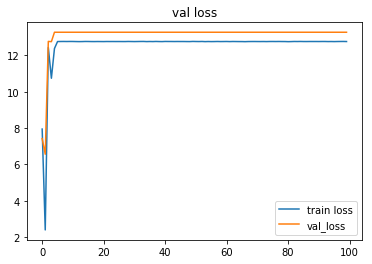

In [90]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

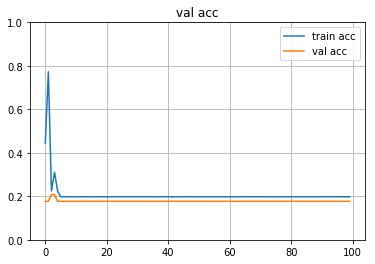

In [91]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train acc', 'val acc'])
plt.grid(True)
plt.ylim(0,1)

In [149]:
gestures = ['none', 'left', 'right', 'click', 'wrist']

In [15]:
np.save('X.npy', X)
np.save('y.npy', y)